In [1]:
%matplotlib inline
import numpy as np
import glob
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from earthshine import smooth
import starry_beta
import starry
from scipy import ndimage

# Load the VIIRS images
files = glob.glob("../data/viirs/sector1/*.jpeg") + glob.glob("../data/viirs/sector2/*.jpeg")
print(len(files))
images = []
for file in files:
    img = np.asarray(Image.open(file)) / 255.
    csum = np.sum(img, axis=-1)
    img[csum == 0] = [np.nan, np.nan, np.nan]
    images.append(img)
images = np.array(images)

28


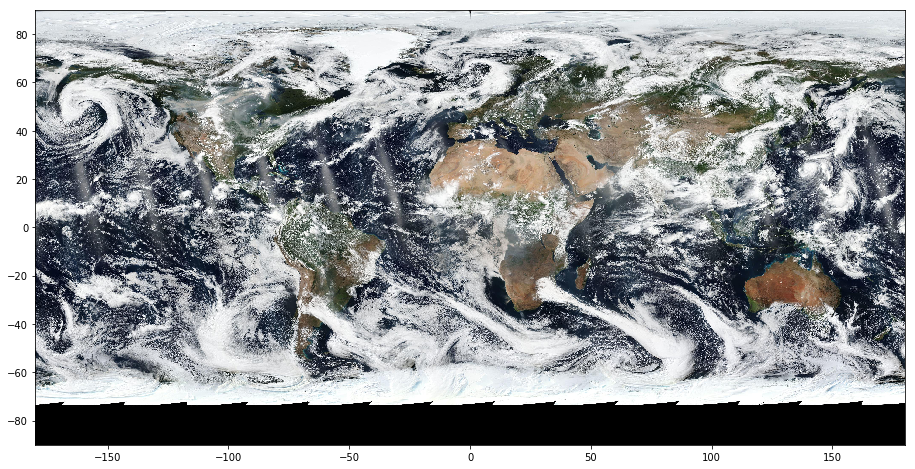

In [2]:
# Plot a sample image
fig, ax = plt.subplots(1, figsize=(16, 8))
plt.imshow(images[0], extent=(-180, 180, -90, 90));

100%|██████████| 28/28 [00:19<00:00,  1.47it/s]


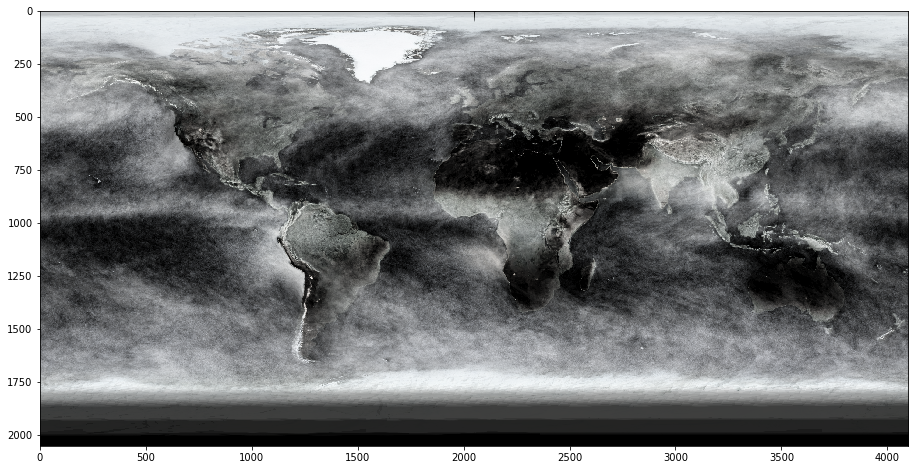

In [3]:
# Clouds as a stddev cut on the RGB colors (they should be *white*)
clouds = np.array(images)
for n in tqdm(range(len(clouds))):
    inds = (np.std(clouds[n], axis=2) / np.mean(clouds[n], axis=2) < 0.05)
    clouds[n][~inds, :] = 0
avgclouds = np.nanmean(clouds, axis=0)
fig, ax = plt.subplots(1, figsize=(16, 8))
plt.imshow(avgclouds);

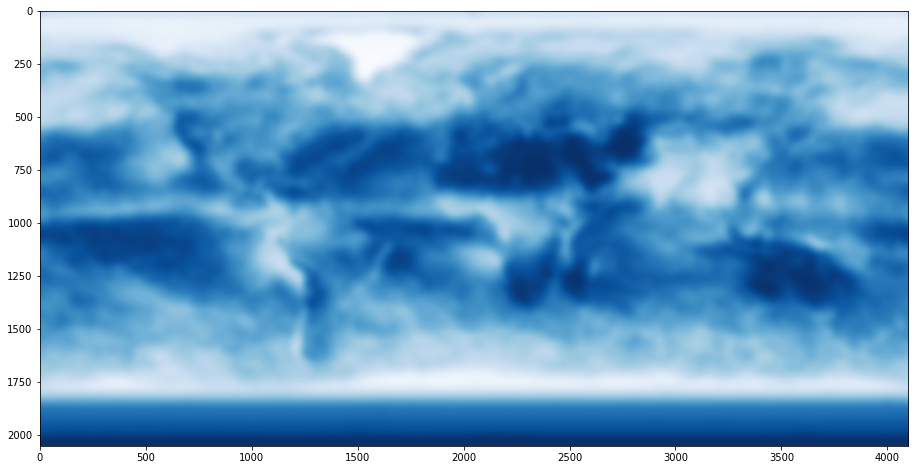

In [4]:
# Monochrome
avggrey = np.nanmean(avgclouds, axis=-1)

# Blur it
avggrey = ndimage.gaussian_filter(avggrey, sigma=20)
avggrey = (avggrey - np.nanmin(avggrey)) / (np.nanmax(avggrey) - np.nanmin(avggrey))

fig, ax = plt.subplots(1, figsize=(16, 8))
plt.imshow(avggrey, cmap="Blues_r");

In [8]:
# Load the image
map_ = starry_beta.Map(25)
map_.load_image(avggrey)
map = starry.Map(25)
map[:, :] = map_[:, :]

# Smooth it a little
smooth(map, sigma=0.05)

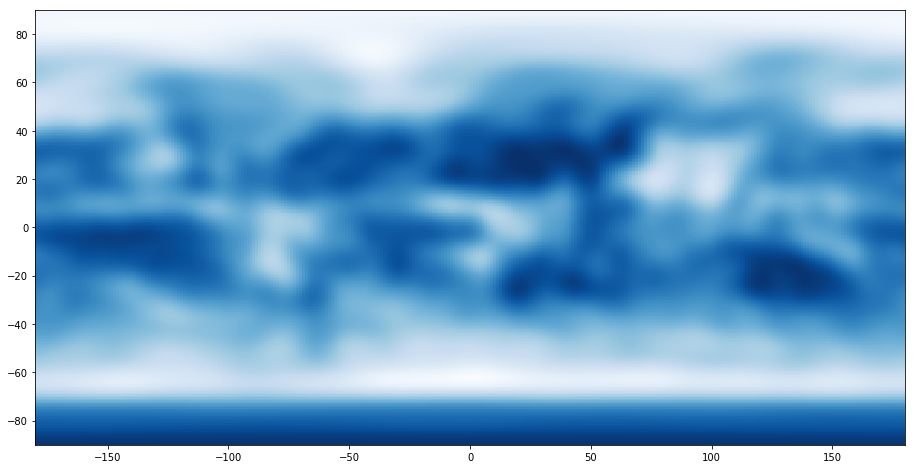

In [9]:
# Render it
Z = map.render(projection="rect")[0]
fig, ax = plt.subplots(1, figsize=(16, 8))
plt.imshow(Z, cmap="Blues_r", origin="lower", extent=(-180, 180, -90, 90));

In [10]:
np.savez("viirs.npz", Ztru=Z)